# Airbnb Price Recommendation with NLP
## Jakub Barber
## Filip Dziurdzia

This project focuses on developing a predictive model for Airbnb listing prices in New York City and London, utilizing data sourced from Inside Airbnb. The core of this work involves building a regression model to accurately estimate accommodation costs. A key component of our methodology is the application of Natural Language Processing (NLP) techniques to extract meaningful features from the textual descriptions of listings. By incorporating these NLP-derived insights alongside traditional features like property type, number of rooms, and location, we aim to create a more nuanced and precise pricing tool. The practical implication of such a model is significant, offering both hosts and travelers a means to quickly ascertain fair market values, thereby streamlining the decision-making process and reducing the time spent on manual price comparisons.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from rnd.domain.poc.city import AvailableCity
from rnd.rbnb.data_provider import load_rbnb_listing_data

ny_data = load_rbnb_listing_data(AvailableCity.NEW_YORK)
london_data = load_rbnb_listing_data(AvailableCity.LONDON)


The foundation of our analysis rests on data loading and validation pipeline. We utilize the `pandera` library to enforce a strict schema, `ListingDataFrame`, ensuring data integrity and consistency from the outset. This schema defines the expected data type for each feature and any specific constraints, such as permissible values for categorical fields (e.g., `city` being restricted to 'NEW_YORK' or 'LONDON').

The `ListingDataFrame` schema, as defined in your `listing.py` file, outlines the core features extracted for each Airbnb listing. These include:

*   **Identification and Basic Info:** `id`, `listing_url`, `name`, `description`, `host_id`
*   **Host Details:** `host_is_superhost`
*   **Location:** `city`, `neighbourhood_cleansed`, `latitude`, `longitude`
*   **Property Specifics:** `property_type`, `room_type`, `accommodates`, `bathrooms`, `bedrooms`, `beds`
*   **Pricing and Availability:** `price`, `availability_365`
*   **Reviews:** `number_of_reviews`, `review_scores_rating`, `reviews_per_month`
*   **Booking:** `instant_bookable`

This structured approach is applied uniformly when loading the datasets for both New York City and London, providing a consistent base for subsequent exploration and modeling. The schema validation helps catch potential data quality issues early on, such as incorrect data types or unexpected missing values (where not explicitly allowed, like for `bathrooms` or `price`).

Once the data for New York and London listings is loaded and validated against this schema, we proceed with an initial exploratory data analysis (EDA). This involves:

1.  **Basic Inspection:** We start by examining the basic characteristics of each dataset, such as the number of listings (rows) and features (columns), and viewing the first few rows (`head()`) and data type information (`info()`) to get a feel for the data.
2.  **Data Completeness:** We then investigate the completeness of the data. This includes concatenating the New York and London datasets and creating a `data_status` column to identify rows with any missing values. We pay particular attention to the `price` column, visualizing its completeness for each city. Similarly, we assess missing values in crucial property features like `bedrooms`, `beds`, and `bathrooms`.
3.  **Price Analysis and Outlier Treatment:** A significant part of the EDA is understanding the distribution of the target variable, `price`. We calculate summary statistics (mean, median, min, max, standard deviation) grouped by city. Violin plots are used to visualize the price distribution. Given the potential for extreme values in pricing data, we implement a standard outlier removal technique (based on the Interquartile Range - IQR) for the `price` column and then re-examine the summary statistics and distributions.
4.  **Geospatial Exploration:** To understand the spatial patterns of listings and their prices, we utilize `geopandas` and `contextily`. We plot the listings on a map, with points colored according to their price. For context, major city landmarks are also plotted on these maps. This helps in visually identifying price clustering and potential correlations with location.

These initial exploratory steps are crucial for understanding the dataset's structure, quality, and inherent patterns before moving on to more complex feature engineering and modeling.

In [1]:
from rnd.domain.poc.city import AvailableCity
from rnd.rbnb.data_provider import load_rbnb_listing_data

ny_data = load_rbnb_listing_data(AvailableCity.NEW_YORK)
london_data = load_rbnb_listing_data(AvailableCity.LONDON)


In [2]:
# New York
print("\nNew York Listings - Info:")
print(ny_data.info())
# print(ny_data.head())



New York Listings - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37782 entries, 0 to 37781
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       37782 non-null  int64  
 1   listing_url              37782 non-null  object 
 2   name                     37782 non-null  object 
 3   description              36809 non-null  object 
 4   host_id                  37782 non-null  int64  
 5   host_is_superhost        37782 non-null  bool   
 6   neighbourhood_cleansed   37782 non-null  object 
 7   latitude                 37782 non-null  float64
 8   longitude                37782 non-null  float64
 9   property_type            37782 non-null  object 
 10  room_type                37782 non-null  object 
 11  accommodates             37782 non-null  int64  
 12  bathrooms                22985 non-null  float64
 13  bedrooms                 31974 non-null  float64


In [25]:
print("\nLondon Listings - Info:")
print(london_data.info())


London Listings - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95144 entries, 0 to 95143
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       95144 non-null  int64  
 1   listing_url              95144 non-null  object 
 2   name                     95144 non-null  object 
 3   description              92196 non-null  object 
 4   host_id                  95144 non-null  int64  
 5   host_is_superhost        95144 non-null  bool   
 6   neighbourhood_cleansed   95144 non-null  object 
 7   latitude                 95144 non-null  float64
 8   longitude                95144 non-null  float64
 9   property_type            95144 non-null  object 
 10  room_type                95144 non-null  object 
 11  accommodates             95144 non-null  int64  
 12  bathrooms                62744 non-null  float64
 13  bedrooms                 82794 non-null  float64
 1

In [26]:
all_listings = pd.concat([ny_data, london_data], ignore_index=True)
all_listings['data_status'] = all_listings.notna().all(axis=1).map({True: 'Complete', False: 'Incomplete'})


Following the initial data loading and schema validation, the next critical step was to assess data completeness. This is particularly important for core features, and most crucially, for our target variable: `price`.

Our combined dataset comprises 95,144 listings for London and 37,782 for New York City. Upon inspection, a significant challenge emerged regarding missing `price` data. For the New York dataset, nearly half of the listings lacked price information. The London dataset also presented a considerable number of unlabeled entries, with approximately one-third of listings missing the `price` value. Given that `price` is the feature we aim to predict, our primary and ultimately final approach to handle these missing values was to remove all records that did not have an associated price.

Beyond the `price` column, we also observed a substantial number of missing values for other key property features, namely `bedrooms`, `beds`, and `bathrooms`. The proportion of missing data for these features was broadly similar to that observed for the `price`. In subsequent stages of this analysis, we will investigate the impact of these incomplete records. Specifically, we plan to test various models and evaluate how the inclusion or exclusion of listings with missing data in these features affects the overall performance of our price prediction model.

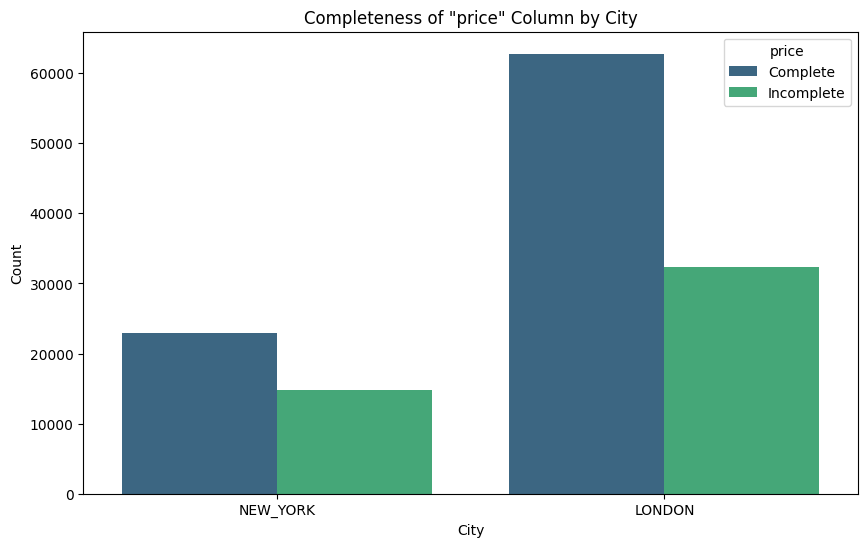

In [27]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=all_listings['price'].isna().map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "price" Column by City')
plt.show()


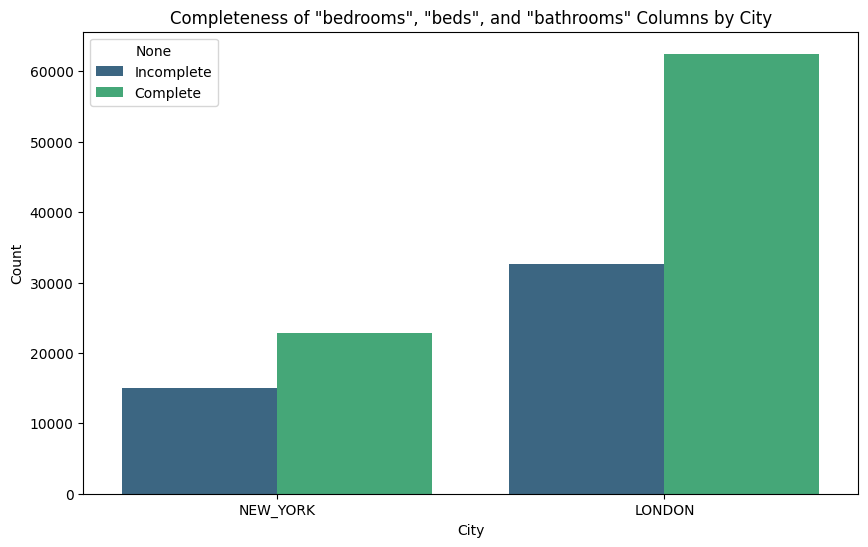

In [28]:
missing_bed_data = all_listings[['bedrooms', 'beds', 'bathrooms']].isna().any(axis=1)

plt.figure(figsize=(10, 6))

sns.countplot(
    data=all_listings,
    x='city',
    hue=missing_bed_data.map({True: 'Incomplete', False: 'Complete'}),
    palette='viridis'
)

plt.xlabel('City')
plt.ylabel('Count')
plt.title('Completeness of "bedrooms", "beds", and "bathrooms" Columns by City')
plt.show()


Following the assessment of data completeness, we focused on understanding the distribution of our target variable, price. An initial examination revealed the presence of outliers, which could disproportionately influence model training. To address this, we implemented a standard outlier removal technique based on the Interquartile Range (IQR). Specifically, for each city's dataset, we retained only those listings with prices falling between the first quartile (Q1 - 1.5 * IQR) and the third quartile (Q3 + 1.5 * IQR).

After applying this outlier treatment, the price distributions for both New York City and London showed notable similarities. Not only did the shapes of the distributions appear comparable, but the actual price ranges also converged. For both cities, the majority of listings fell within a range of approximately $40 to $400, with a significant concentration of prices observed between $50 and $150. This normalization of the price data provides a more robust foundation for subsequent modeling efforts.

       city  count  nan_count        mean  median  min      max         std
0    LONDON  62777      32367  207.141581   134.0  1.0  80000.0  774.707797
1  NEW_YORK  22969      14813  195.224128   132.0  8.0  20000.0  353.251037


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/3518765710.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


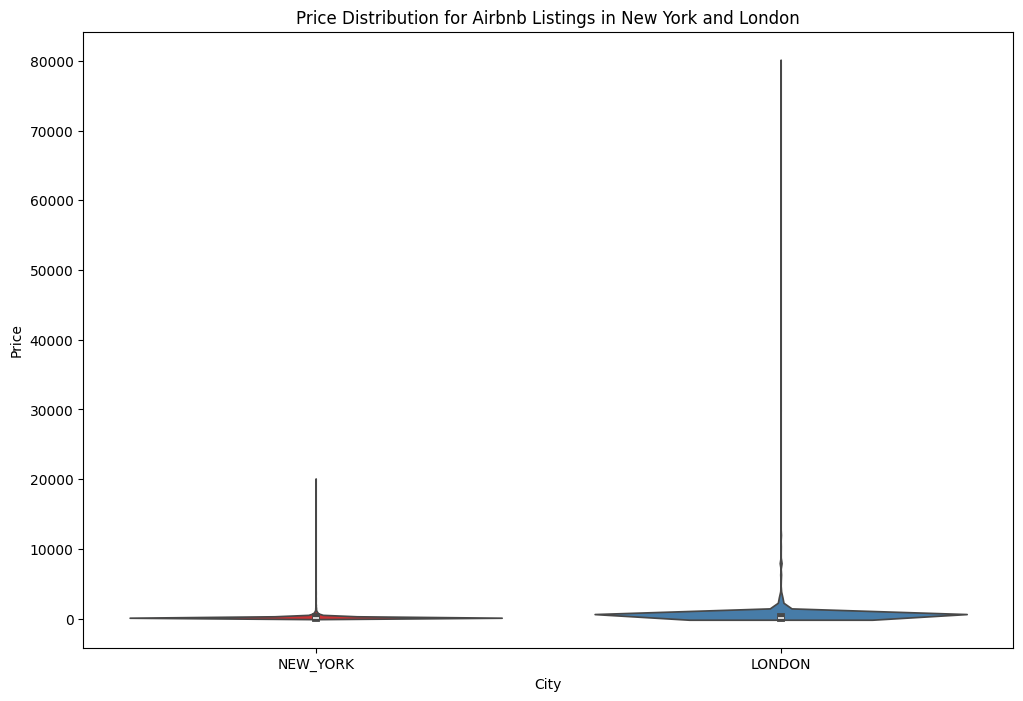

In [29]:
price_summary = all_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)



plt.figure(figsize=(12, 8))

sns.violinplot(
    data=all_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()


       city  count  nan_count        mean  median  min    max        std
0    LONDON  58480          0  144.559439   125.0  1.0  422.0  87.720125
1  NEW_YORK  21505          0  147.709509   125.0  8.0  422.0  88.972629


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/860953171.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


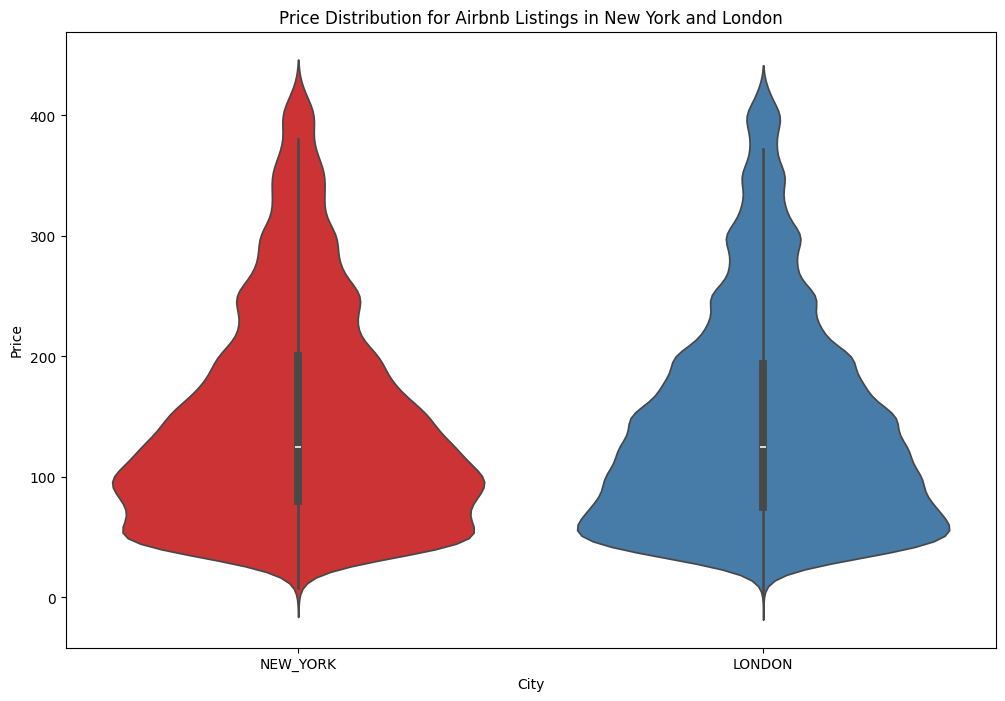

In [30]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

cleaned_listings = remove_outliers(all_listings, 'price')
price_summary = cleaned_listings.groupby('city')['price'].agg(
    count='count',
    nan_count=lambda x: x.isna().sum(),
    mean='mean',
    median='median',
    min='min',
    max='max',
    std='std'
).reset_index()
print(price_summary)

plt.figure(figsize=(12, 8))

sns.violinplot(
    data=cleaned_listings,
    x='city',
    y='price',
    palette='Set1'
)

plt.xlabel('City')
plt.ylabel('Price')
plt.title('Price Distribution for Airbnb Listings in New York and London')

plt.show()



In [31]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from rnd.rbnb.geospatial_features.transform import landmarks

def plot_map_with_price(df, city: AvailableCity):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column='price', cmap='viridis', legend=True, markersize=0.5, alpha=0.3, ax=ax)
    ctx.add_basemap(ax, crs=gdf.crs)

    if city_landmarks:= landmarks.get(city):
        landmark_df = gpd.GeoDataFrame(
            city_landmarks,
            geometry=[Point(lon, lat) for lon, lat in zip(
                [lm['longitude'] for lm in city_landmarks],
                [lm['latitude'] for lm in city_landmarks]
            )],
            crs="EPSG:4326"
        )
        landmark_df.plot(ax=ax, color='red', marker='*', markersize=100, label='Landmark')

        for _, row in landmark_df.iterrows():
            ax.text(row.geometry.x, row.geometry.y, row['name'], fontsize=8, ha='left', va='bottom', color='red')

    plt.title(f'Property Prices by Location in {city.name.replace("_"," ".capitalize())}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


To enhance our dataset's predictive power, we augmented the existing latitude and longitude data with additional contextual geospatial features.

1.  **Landmark Proximity:** We curated a list of approximately 10-15 key landmarks for each city (New York and London). These landmarks primarily consist of major tourist attractions, and we incorporated their specific geographic coordinates. This allows us to potentially capture the influence of proximity to popular sites on listing prices. The values for the metrics are actual distances from apartment coordinates to the landmarks themselves.

2.  **Distance to Nearest Metro Station:** While initially considering various other geospatial metrics such as distance to the closest bus stop, we ultimately decided to focus on a crucial urban accessibility feature: the distance to the nearest metro station. To calculate these distances accurately, we leveraged a combination of libraries:
    *   `osmnx` for fetching OpenStreetMap data, specifically subway station locations.
    *   `geopy` and `geopandas` (along with `shapely` for geometric operations) for precise calculation of geodesic distances between each listing and the identified metro stations.

The process of deriving these geospatial features, particularly the distance calculations for every listing against all potential metro stations, proved to be computationally intensive. Considering this overhead, and our assessment that adding a vast number of similar geo-features might not yield proportionally significant benefits for our models, we believe our selected approach strikes a good balance. It enriches the dataset with meaningful location-based context without an excessive computational burden.

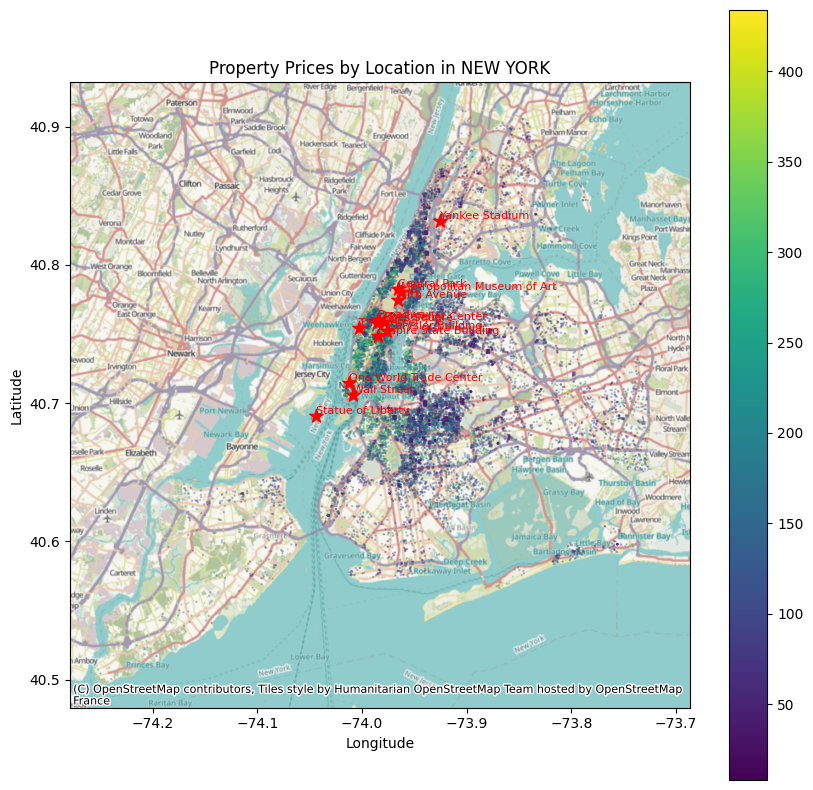

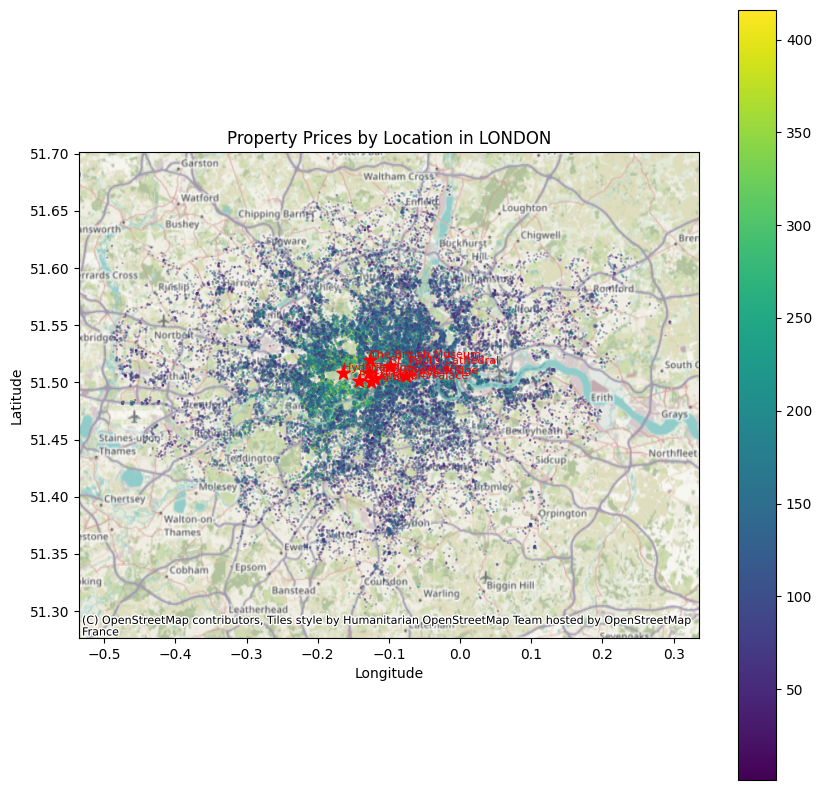

In [32]:
plot_map_with_price(remove_outliers(ny_data, 'price'), AvailableCity.NEW_YORK)
plot_map_with_price(remove_outliers(london_data, 'price'), AvailableCity.LONDON)


Geospatial analysis, visualizing listing prices on a map, revealed distinct price variations across different districts within both cities. A clear pattern emerged, indicating that properties situated in and around city centers, and in close proximity to major landmarks, tend to command higher prices. This observation underscores the strong correlation between a listing's location, particularly its nearness to key attractions and central areas, and its rental price.

#### Categorical columns value exploration for NY and London

The final stage of our data preparation involved processing the categorical features present in the dataset. The initial set of categorical columns considered was: `listing_url`, `name`, `description`, `host_is_superhost`, `neighbourhood_cleansed`, `property_type`, `room_type`, `instant_bookable`, and `city`.

First, we analyzed the uniqueness and range of values for these columns. Several columns were immediately identified as non-informative for our modeling purposes and were subsequently dropped: `listing_url`, `name`, `host_id`, `id`. The `city` column was also removed as we are developing separate models for New York and London.

Our strategy for handling the remaining key categorical features was as follows:

1.  **`neighbourhood_cleansed`**:
    Recognizing the potential impact of neighborhood on price, especially in conjunction with our geospatial features (latitude/longitude), we opted for label encoding for this feature. Both datasets (New York and London) contain a significant number of unique neighborhoods. For the London dataset, most neighborhoods had a substantial number of listings (several hundred), which is ideal for label encoding. The New York dataset, while also diverse, included some neighborhoods with very few listings. We proceeded with label encoding for New York as well, intending to monitor its performance during model evaluation.

2.  **`property_type` and `description` Consolidation into `property_type_label`**:
    The original `property_type` feature, while useful, could be enhanced by considering the rich information within the listing `description` and `name`. To create a more semantically meaningful categorization, we decided to assign each listing to one of several predefined `property_type_label` categories.

    We defined the following target categories, each with a descriptive sentence to guide the classification:
    *   **Luxury**: Encompasses properties distinguished by premium amenities, high-end furnishings, and exclusive features, offering a top-tier guest experience.
    *   **Unique Stay**: Pertains to unconventional accommodations that offer a distinct experience, such as tents, boats, campers, treehouses, or other non-standard dwelling types, rather than traditional homes or apartments.
    *   **Shared**: Describes listings where guests rent a shared room within a larger rental unit or home. This implies sharing common spaces like the kitchen, living room, or bathrooms with the host or other guests.
    *   **Private Room**: Refers to a private room within a home, apartment, or condominium. While the guest has a dedicated sleeping space, common areas might be shared. Some private rooms may offer a private bathroom or a separate entrance.
    *   **Entire Home/Apartment**: Indicates that the guest rents an entire, self-contained dwelling, such as a whole house, apartment, or condominium, ensuring complete privacy and access to all its amenities.
    *   **Hotel/Commercial**: Covers rooms in traditional hospitality establishments like hotels, boutique hotels, aparthotels, or serviced apartments. These typically include professional services and may not be residential properties.

    To assign each listing to one of these categories, we created a combined text field using the original `property_type`, `name`, and `description` (filling missing descriptions with an empty string). We then utilized a pre-trained Sentence Transformer model (`all-MiniLM-L6-v2`) to generate embeddings for both our combined listing texts and the descriptive sentences of our target categories. By calculating the cosine similarity between each listing's embedding and each category's embedding, we assigned the listing to the category with the highest similarity score.
    Initial testing on a smaller subset of the data indicated that this approach performed effectively in categorizing listings according to our defined labels.

3.  **Final Categorical Encoding**:
    After successfully generating the `property_type_label`, we dropped the original `property_type`, `description`, and `name` columns, as their information was now captured in the new label. For the `property_type_label` itself, and other remaining categorical features like `room_type`, `host_is_superhost`, and `instant_bookable`, we applied standard label encoding to convert them into numerical representations suitable for machine learning models.

In [33]:
ny_data = ny_data.dropna(subset=['price'])
london_data = london_data.dropna(subset=['price'])

print(f"Shape of New York dataset after removing rows with missing price: {ny_data.shape}")
print(f"Shape of London dataset after removing rows with missing price: {london_data.shape}")

Shape of New York dataset after removing rows with missing price: (22969, 36)
Shape of London dataset after removing rows with missing price: (62777, 31)


In [34]:
from collections import Counter
categorical_columns = ['listing_url', 'name', 'description', 'host_is_superhost', 
                      'neighbourhood_cleansed', 'property_type', 'room_type',
                      'instant_bookable', 'city']

def explore_categorical_columns(df:pd.DataFrame, categorical_columns:list[str] = categorical_columns)->None:
    for col in categorical_columns:
        print(f"\n{col}:")
        print("\tNumber of unique values:", df[col].nunique())
        print("\tSample unique values:", df[col].unique()[:5])
        print("\tNumber of missing values:", df[col].isna().sum())
    print("-"*50)
    print("\nCounts of unique values in 'property_type':")
    for key,value in sorted(Counter(df['property_type']).items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")
    print("\nCounts of unique values in 'neighbourhood_cleansed':")
    for key,value in sorted(Counter(df['neighbourhood_cleansed']).items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")

In [35]:
explore_categorical_columns(ny_data)


listing_url:
	Number of unique values: 22969
	Sample unique values: ['https://www.airbnb.com/rooms/39572' 'https://www.airbnb.com/rooms/39593'
 'https://www.airbnb.com/rooms/42300' 'https://www.airbnb.com/rooms/42729'
 'https://www.airbnb.com/rooms/43105']
	Number of missing values: 0

name:
	Number of unique values: 22025
	Sample unique values: ['1 br in a 2 br apt (Midtown West)' 'A lovely room w/ a Manhattan view'
 'Beautiful Lower East Side Loft'
 '@HouseOnHenrySt - Private 2nd bedroom w/shared use'
 'Studio 3 blocks from Empire State Building']
	Number of missing values: 0

description:
	Number of unique values: 18444
	Sample unique values: [nan
 'A private, furnished  large room to rent Jan/Feb/25 in an apt unit w/ a city view, near the historic Sunnyside Garden. Subway #7, Q60 & Q32 bus lines in 1.5 blocs; easy transfer to E/F/N/G lines for midtown, downtown & Brooklyn. Availability uncertain from March on (please inquire within). Non-smoking, no-drinking, no-pet woman-to woman

In [36]:
explore_categorical_columns(london_data)


listing_url:
	Number of unique values: 62777
	Sample unique values: ['https://www.airbnb.com/rooms/56229' 'https://www.airbnb.com/rooms/62970'
 'https://www.airbnb.com/rooms/63948' 'https://www.airbnb.com/rooms/66772'
 'https://www.airbnb.com/rooms/69198']
	Number of missing values: 0

name:
	Number of unique values: 60478
	Sample unique values: ['Cosy Double studio in Zone 2 Hammersmith (1)'
 '3 Bedrm with Garden off Brick lane refurbd Oct24'
 'Cosy Double studio in Zone 2 Hammersmith (4)'
 'Cosy Double studio in Zone 2 Hammersmith (3)'
 'Spacious single room in quiet flat']
	Number of missing values: 0

description:
	Number of unique values: 52597
	Sample unique values: [nan
 "Recently renovated  (Oct 2024) warehouse conversion with considerable outside space. The apartment is moments from Brick Lane in Shoreditch! Spacious luxury 3 bedroom & 3 bathroom duplex/maisonette apartment in the centre of arguably London's trendiest & liveliest location. The apt is in Zone 1 and a 5 min wal

#### Preprocessing the categorical features

**neighbourhood_cleansed** - as this might indeed be impactful and informative combined with our geological data (latitude/longitude) we will use label encoding for that, as for both datasets we have quite a few values. Fortunately, we rather don't have a single representants for any subarea - they have at least couple hundred representants which is great for london dataset. On the other hand, NY dataset contains single representants, but we will treat them normally and see how it peerforms.

In [38]:
from sklearn.preprocessing import LabelEncoder

ny_neighbourhood_cleansed_label_encoder = LabelEncoder()
london_neighbourhood_cleansed_label_encoder = LabelEncoder()
ny_data['neighbourhood_cleansed'] = ny_neighbourhood_cleansed_label_encoder.fit_transform(ny_data['neighbourhood_cleansed'])
london_data['neighbourhood_cleansed'] = london_neighbourhood_cleansed_label_encoder.fit_transform(london_data['neighbourhood_cleansed'])


For `property_type` it makes perfect sense to combine it with descriptions, to assign it to one of the groups. For that We've chosen to start with predefined categories and choose the group with highest similarity for each observation. We've predefined couple groups based on initial investigation of the results for those texts.

In [39]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

target_categories = {
    "Luxury": "A luxurious property with premium amenities, high-end furnishings, and exclusive features.",
    "Unique Stay": "A truly unconventional accommodation such as a tent, boat, camper, or other non-standard property. Typically not a traditional home or apartment.",
    "Shared": "A shared room in a rental unit or home, shared home,  where guests share common spaces like the kitchen or living room.",
    "Private Room": "A private room in a home or condo with its own bathroom or entrance.",
    "Entire Home/Apartment": "An entire rental unit, apartment, or condo with full privacy and amenities.",
    "Hotel/Commercial": "A room in a hotel, boutique hotel, or serviced apartment with professional services included (not nearby restaurants)."
}

def assign_property_type_to_df(df: pd.DataFrame, target_column_name: str, target_categories: dict[str,str] = target_categories):
    df['combined_text'] = df['property_type'] + " " + df['description'].fillna("")
    df[target_column_name] = assign_property_type(df, text_column='combined_text', target_categories=target_categories
    )
    df.drop(columns=['combined_text'], inplace=True)
    return df

def assign_property_type(df: pd.DataFrame, text_column : str, target_categories: dict[str,str] = target_categories):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    category_embeddings = {category: model.encode(sentence) for category, sentence in target_categories.items()}
    text_embeddings = model.encode(df[text_column].fillna("").tolist(), show_progress_bar=True)

    def assign_category(embedding):
        similarities = {category: cosine_similarity([embedding], [category_embedding])[0][0]
                        for category, category_embedding in category_embeddings.items()}
        return max(similarities, key=similarities.get)

    return pd.Series([assign_category(embedding) for embedding in text_embeddings], index=df.index)

def print_labeling_results(data: pd.DataFrame, test_results: pd.Series):
    print("\nLabeling Results:")
    print("-" * 120)
    print(f"{'Index':<10} {'Property Type':<30} {'Assigned Category':<20} {'Description':<50}")
    print("-" * 120)
    for index, row in data.iterrows():
        print(f"{index:<10} {row['property_type']:<30} {test_results[index]:<20} {row['description']}")
        print("-" * 120)

/Users/filipdziurdzia/Desktop/Uni/Semestr 8/Eksploracja Danych/Data-Exploration/venv1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing the implementation for labeling the luxury label of the dataset

In [40]:
test_data = ny_data.sample(10, random_state=42)
test_data['combined_text'] = test_data['property_type'] + " " + test_data['description'].fillna("")

test_results = assign_property_type(test_data, text_column='combined_text')

print_labeling_results(test_data, test_results)

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
13807      Private room in home           Private Room         Spacious comfort in the heart of Brooklyn.<br />Elegantly renovated apartment. The entrance leads you to an open Kitchen and Living room to your left. Natural sun light exposure, wooden cabinetry & appliances. New wood floors and clean bathroom.
------------------------------------------------------------------------------------------------------------------------
21470      Tiny home                      Shared               Embrace comfort in our inviting Schuylerville Bronx studio, ideal for professionals or couples seeking an extended stay. Unwind on a

#### Labeling NY Data

In [41]:
ny_data = assign_property_type_to_df(ny_data, 'property_type_label')

Batches: 100%|██████████| 718/718 [00:42<00:00, 16.89it/s]



Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
13807      Private room in home           Private Room         Spacious comfort in the heart of Brooklyn.<br />Elegantly renovated apartment. The entrance leads you to an open Kitchen and Living room to your left. Natural sun light exposure, wooden cabinetry & appliances. New wood floors and clean bathroom.
------------------------------------------------------------------------------------------------------------------------
21470      Tiny home                      Shared               Embrace comfort in our inviting Schuylerville Bronx studio, ideal for professionals or couples seeking an extended stay. Unwind on a

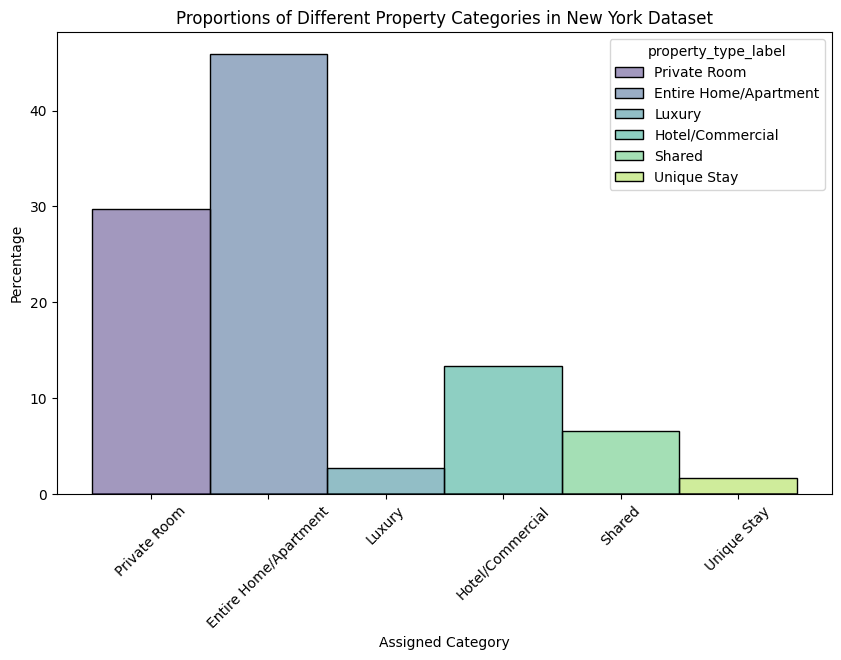

In [42]:
sample_ny_data = ny_data.sample(5, random_state=42)
print_labeling_results(sample_ny_data, ny_data['property_type_label'])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=ny_data,
    x='property_type_label',
    stat='percent',
    discrete=True,
    hue='property_type_label',
    palette='viridis'
)
plt.xlabel('Assigned Category')
plt.ylabel('Percentage')
plt.title('Proportions of Different Property Categories in New York Dataset')
plt.xticks(rotation=45)
plt.show()

#### Labeling London Data

In [43]:
london_data = assign_property_type_to_df(london_data, 'property_type_label')

Batches: 100%|██████████| 1962/1962 [01:25<00:00, 22.84it/s]



Labeling Results:
------------------------------------------------------------------------------------------------------------------------
Index      Property Type                  Assigned Category    Description                                       
------------------------------------------------------------------------------------------------------------------------
53855      Entire rental unit             Hotel/Commercial     Enjoy a stylish experience at this centrally-located place.<br /><br />Classy studio apartment located in the famous Notting Hill Area in London.<br /><br />This interior designed apartment is in a grand Victorian townhouse, on a beautiful and quiet tree-lined street<br /><br />One set of towels per person and one set of linen are provided.<br /><br />Feel free to send me a message even if your dates are not available on the calendar.<br /><br />I will do my best to help you.<br /><br />Looking forward to hosting you!
--------------------------------------

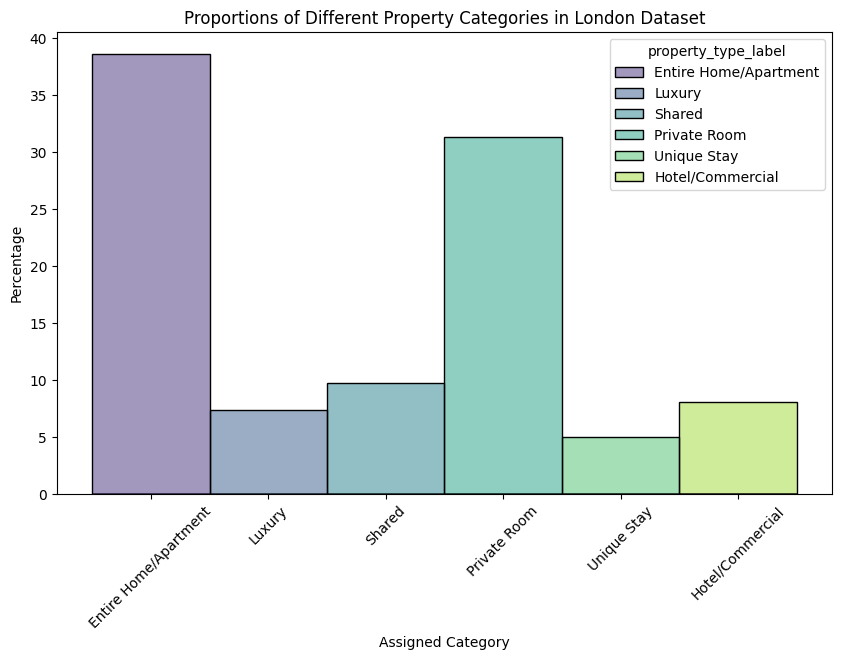

In [44]:
sample_london_data = london_data.sample(5, random_state=42)
print_labeling_results(sample_london_data, london_data['property_type_label'])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=london_data,
    x='property_type_label',
    stat='percent',
    discrete=True,
    hue='property_type_label',
    palette='viridis'
)
plt.xlabel('Assigned Category')
plt.ylabel('Percentage')
plt.title('Proportions of Different Property Categories in London Dataset')
plt.xticks(rotation=45)
plt.show()

### Final data preprocessing and splitting into train and test sets prior to training models

In [45]:
from sklearn.preprocessing import LabelEncoder

ny_property_type_label_encoder = LabelEncoder()
london_property_type_label_encoder = LabelEncoder()
ny_room_type_label_encoder = LabelEncoder()
london_room_type_label_encoder = LabelEncoder()

ny_data['property_type_label'] = ny_property_type_label_encoder.fit_transform(ny_data['property_type_label'])
london_data['property_type_label'] = london_property_type_label_encoder.fit_transform(london_data['property_type_label'])
ny_data['room_type'] = ny_room_type_label_encoder.fit_transform(ny_data['room_type'])
london_data['room_type'] = london_room_type_label_encoder.fit_transform(london_data['room_type'])

In [46]:

columns_to_drop = ['property_type', 'description', 'id', 'host_id',"listing_url","name","city"]

X_ny = ny_data.drop(columns=columns_to_drop, errors='ignore')
X_ny = X_ny.drop(columns=['price'], errors='ignore')
y_ny = ny_data['price']


X_london = london_data.drop(columns=columns_to_drop, errors='ignore')
X_london = X_london.drop(columns=['price'], errors='ignore')
y_london = london_data['price']

#### Training LGMB and evaluating model

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

def train_and_evaluate(X, y, drop_null =False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = lgb.LGBMRegressor(num_boost_round=100, verbose=1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }

    return model, metrics

In [ ]:
# import lightgbm as lgb
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def preprocess_and_train(df, target_col="price"):
#     df = df.copy()

#     # Clean column names: remove spaces and special characters
#     df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
#     df.columns = df.columns.str.replace(r"__+", "_", regex=True)  # Replace multiple underscores
#     df.columns = df.columns.str.strip("_")  # Remove leading/trailing underscores

#     # Convert categorical variables to one-hot encoding
#     categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
#     df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#     df.columns = df.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)

#     def make_unique(column_names):
#         seen = {}
#         unique_names = []
#         for col in column_names:
#             if col in seen:
#                 seen[col] += 1
#                 unique_names.append(f"{col}_{seen[col]}")
#             else:
#                 seen[col] = 0
#                 unique_names.append(col)
#         return unique_names

#     df.columns = make_unique(df.columns)
#     print(df.columns)

#     # Split data into features and target
#     X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
#     y = df[target_col]

#     # Sample only 100 rows for quick validation
#     X_sample, y_sample = X.iloc[:100], y.iloc[:100]

#     X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

#     # Train LightGBM model
#     model = lgb.LGBMRegressor(n_estimators=100, verbose=1)
#     model.fit(X_train, y_train)

#     # Predictions
#     y_pred = model.predict(X_test)

#     # Evaluation metrics
#     metrics = {
#         "MAE": mean_absolute_error(y_test, y_pred),
#         "MSE": mean_squared_error(y_test, y_pred),
#         "R2 Score": r2_score(y_test, y_pred)
#     }

#     return model, metrics

In [48]:
print(train_and_evaluate(X_ny, y_ny)[1])
print(train_and_evaluate(X_ny, y_ny, drop_null=True)[1])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5211
[LightGBM] [Info] Number of data points in the train set: 18375, number of used features: 29
[LightGBM] [Info] Start training from score 193.802830
{'MAE': 85.60370612467366, 'MSE': 157402.74623985367, 'R2 Score': 0.20675656408271514}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5193
[LightG

In [49]:
print(train_and_evaluate(X_london, y_london)[1])
print(train_and_evaluate(X_london, y_london, drop_null=True)[1])

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3834
[LightGBM] [Info] Number of data points in the train set: 50221, number of used features: 24
[LightGBM] [Info] Start training from score 205.550686
{'MAE': 113.43947820913237, 'MSE': 938742.9160461728, 'R2 Score': 0.036131781936085794}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3821
[Light

### Training LightGBM on New York listing data without additional geospartial features

In [50]:
X_ny_without_geo_features = X_ny.loc[:, ~X_ny.columns.str.contains("dist", case=False)]
X_london_without_geo_features = X_london.loc[:, ~X_london.columns.str.contains("dist", case=False)]

print("London, Shape without geo features:", X_london_without_geo_features.shape)
print("New York, Shape without geo features:", X_ny_without_geo_features.shape)
print("London, Shape with geo features:", X_london.shape)
print("New York, Shape with geo features:", X_ny.shape)

London, Shape without geo features: (62777, 15)
New York, Shape without geo features: (22969, 15)
London, Shape with geo features: (62777, 24)
New York, Shape with geo features: (22969, 29)


In [51]:
print(train_and_evaluate(X_ny_without_geo_features, y_ny)[1])
print(train_and_evaluate(X_ny_without_geo_features, y_ny, drop_null=True)[1])

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 18375, number of used features: 15
[LightGBM] [Info] Start training from score 193.802830
{'MAE': 85.53915712815055, 'MSE': 164452.3000492795, 'R2 Score': 0.17122978695170188}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1623
[LightGB

In [52]:
print(train_and_evaluate(X_london_without_geo_features, y_london)[1])
print(train_and_evaluate(X_london_without_geo_features, y_london, drop_null=True)[1])

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 50221, number of used features: 15
[LightGBM] [Info] Start training from score 205.550686
{'MAE': 113.09961084106506, 'MSE': 822786.429479781, 'R2 Score': 0.15519182507382068}
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGB

### Further explorations

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [ ]:
def preprocess_text(df):
    df = df.dropna(subset=['description'])
    return df[['description', 'price']].dropna()

descriptions_ny = preprocess_text(ny_data)
descriptions_london = preprocess_text(london_data)

In [ ]:
print(len(descriptions_ny))
print(len(descriptions_london))

In [ ]:
def lda_features(descriptions, num_topics=10):
    vectorizer = CountVectorizer(stop_words='english', max_features=5000)
    doc_term_matrix = vectorizer.fit_transform(descriptions['description'])
    
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_features = lda_model.fit_transform(doc_term_matrix)
    
    return pd.DataFrame(lda_features, columns=[f'topic_{i}' for i in range(num_topics)]), lda_model, vectorizer

lda_ny, lda_model_ny, vectorizer_ny = lda_features(descriptions_ny)
lda_london, lda_model_london, vectorizer_london = lda_features(descriptions_london)

print("LDA Topics (NYC):")
print(lda_ny)

print("LDA Topics (London):")
print(lda_london)

In [ ]:
import numpy as np

def get_top_words(lda_model, vectorizer, num_words=10):
    words = np.array(vectorizer.get_feature_names_out())
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = words[np.argsort(topic)][-num_words:][::-1]  # Sort and get top words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

# Extract most common words per topic
get_top_words(lda_model_ny, vectorizer_ny, num_words=10)

In [ ]:
from sklearn.linear_model import LinearRegression

X = lda_ny  # Topic distribution per listing
y = descriptions_ny['price']  # Target variable (price)

model = LinearRegression()
model.fit(X, y)

# Get topic influence on price
topic_importance = pd.Series(model.coef_, index=[f'topic_{i}' for i in range(10)])
print(topic_importance.sort_values(ascending=False))


In [ ]:
# def bert_features(descriptions, num_clusters=10):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     embeddings = model.encode(descriptions, show_progress_bar=True)
    
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
    
#     clusters_df = pd.DataFrame({'cluster': clusters})
    
#     descriptions_reset = pd.Series(descriptions).reset_index(drop=True)
#     clusters_df.reset_index(drop=True, inplace=True)

#     return pd.concat([descriptions_reset, clusters_df], axis=1)


# descriptions_ny_list = descriptions_ny['description'].tolist()
# descriptions_london_list = descriptions_london['description'].tolist()



# bert_ny = bert_features(descriptions_ny_list)
# bert_london = bert_features(descriptions_london_list)


In [ ]:
# display(bert_ny)

In [ ]:
# ny_final = pd.concat([descriptions_ny.reset_index(drop=True), lda_ny, bert_ny], axis=1)
# london_final = pd.concat([descriptions_london.reset_index(drop=True), lda_london, bert_london], axis=1)

In [54]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [55]:
def get_bert_embedding(text, tokenizer, model, max_length=128):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return cls_embedding.squeeze().numpy()


In [56]:
import numpy as np
from tqdm import tqdm

def generate_bert_embeddings(df, column="description"):
    embeddings = []
    for text in tqdm(df[column].fillna("").astype(str), desc="BERT Embedding"):
        emb = get_bert_embedding(text, tokenizer, bert_model)
        embeddings.append(emb)
    return np.vstack(embeddings)

In [57]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def preprocess_tabular(df, target_col="price"):
    df = df.copy()

    df.columns = df.columns.str.strip().str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
    df.columns = df.columns.str.replace(r"__+", "_", regex=True).str.strip("_")

    # Convert categorical variables
    categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    def make_unique(column_names):
        seen = {}
        unique_names = []
        for col in column_names:
            if col in seen:
                seen[col] += 1
                unique_names.append(f"{col}_{seen[col]}")
            else:
                seen[col] = 0
                unique_names.append(col)
        return unique_names

    df.columns = make_unique(df.columns)

    # Split features and target
    X = df.drop(columns=[target_col, "id", "listing_url", "name", "description", "city"], errors='ignore')
    y = df[target_col]

    return X, y

def train_with_bert_features(df, bert_embeddings, target_col="price", pca_dim=64):
    # Preprocess tabular features
    X_tabular, y = preprocess_tabular(df, target_col)

    # Optional: Reduce dimensionality of BERT embeddings
    # if pca_dim is not None and bert_embeddings.shape[1] > pca_dim:
    #     pca = PCA(n_components=pca_dim, random_state=42)
    #     bert_embeddings = pca.fit_transform(bert_embeddings)

    # Combine tabular and text features
    X_combined = np.hstack([X_tabular.values, bert_embeddings])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # Train LightGBM model
    model = lgb.LGBMRegressor(num_boost_round=100, verbose=1)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }

    return model, metrics


In [60]:
# bert_embeddings = generate_bert_embeddings(df_complete)

# df_features = df_complete.drop(columns=["description"])

# model_combined, metrics_combined = train_with_bert_features(df_complete, bert_embeddings)

# print("Metrics with BERT features:", metrics_combined)


In [ ]:
ny_property_type_label_encoder = LabelEncoder()
london_property_type_label_encoder = LabelEncoder()
ny_room_type_label_encoder = LabelEncoder()
london_room_type_label_encoder = LabelEncoder()

ny_data['property_type_label'] = ny_property_type_label_encoder.fit_transform(ny_data['property_type_label'])
london_data['property_type_label'] = london_property_type_label_encoder.fit_transform(london_data['property_type_label'])
ny_data['room_type'] = ny_room_type_label_encoder.fit_transform(ny_data['room_type'])
london_data['room_type'] = london_room_type_label_encoder.fit_transform(london_data['room_type'])

columns_to_drop = ['property_type', 'description', 'id', 'host_id', "listing_url", "name", "city"]

X_ny = ny_data.drop(columns=columns_to_drop + ['price'], errors='ignore')
y_ny = ny_data['price']

X_london = london_data.drop(columns=columns_to_drop + ['price'], errors='ignore')
y_london = london_data['price']


In [ ]:
def train_and_evaluate_lgbm(X, y, drop_null=False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = lgb.LGBMRegressor(num_boost_round=100, verbose=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }
    return model, metrics


In [88]:
from sklearn.model_selection import GridSearchCV

def train_and_evaluate_lgbm_tuned(X, y, drop_null=False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = lgb.LGBMRegressor(verbose=-1)

    param_grid = {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [-1, 10, 20]
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred),
        "Best Params": grid_search.best_params_
    }
    return best_model, metrics


In [79]:
def compare(train_and_evaluate, model_name):
    # Pełne dane z geofeatures
    print("NY Full data:")
    metrics_ny_full = train_and_evaluate(X_ny, y_ny)
    print(metrics_ny_full[1])

    print("NY Full data (drop nulls):")
    metrics_ny_full_drop = train_and_evaluate(X_ny, y_ny, drop_null=True)
    print(metrics_ny_full_drop[1])

    print("London Full data:")
    metrics_london_full = train_and_evaluate(X_london, y_london)
    print(metrics_london_full[1])

    print("London Full data (drop nulls):")
    metrics_london_full_drop = train_and_evaluate(X_london, y_london, drop_null=True)
    print(metrics_london_full_drop[1])

    X_ny_no_geo = X_ny.loc[:, ~X_ny.columns.str.contains("dist", case=False)]
    X_london_no_geo = X_london.loc[:, ~X_london.columns.str.contains("dist", case=False)]

    print("NY data without geo features:")
    metrics_ny_no_geo = train_and_evaluate(X_ny_no_geo, y_ny)
    print(metrics_ny_no_geo[1])

    print("NY data without geo features (drop nulls):")
    metrics_ny_no_geo_drop = train_and_evaluate(X_ny_no_geo, y_ny, drop_null=True)
    print(metrics_ny_no_geo_drop[1])

    print("London data without geo features:")
    metrics_london_no_geo = train_and_evaluate(X_london_no_geo, y_london)
    print(metrics_london_no_geo[1])

    print("London data without geo features (drop nulls):")
    metrics_london_no_geo_drop = train_and_evaluate(X_london_no_geo, y_london, drop_null=True)
    print(metrics_london_no_geo_drop[1])


    results = pd.DataFrame({
        "Model": [
            "NY Full",
            "NY Full Drop NA",
            "NY No Geo",
            "NY No Geo Drop NA",
            "London Full",
            "London Full Drop NA",
            "London No Geo",
            "London No Geo Drop NA"
        ],
        "MAE": [
            metrics_ny_full[1]['MAE'],
            metrics_ny_full_drop[1]['MAE'],
            metrics_ny_no_geo[1]['MAE'],
            metrics_ny_no_geo_drop[1]['MAE'],
            metrics_london_full[1]['MAE'],
            metrics_london_full_drop[1]['MAE'],
            metrics_london_no_geo[1]['MAE'],
            metrics_london_no_geo_drop[1]['MAE']
        ],
        "MSE": [
            metrics_ny_full[1]['MSE'],
            metrics_ny_full_drop[1]['MSE'],
            metrics_ny_no_geo[1]['MSE'],
            metrics_ny_no_geo_drop[1]['MSE'],
            metrics_london_full[1]['MSE'],
            metrics_london_full_drop[1]['MSE'],
            metrics_london_no_geo[1]['MSE'],
            metrics_london_no_geo_drop[1]['MSE']
        ],
        "R2": [
            metrics_ny_full[1]['R2 Score'],
            metrics_ny_full_drop[1]['R2 Score'],
            metrics_ny_no_geo[1]['R2 Score'],
            metrics_ny_no_geo_drop[1]['R2 Score'],
            metrics_london_full[1]['R2 Score'],
            metrics_london_full_drop[1]['R2 Score'],
            metrics_london_no_geo[1]['R2 Score'],
            metrics_london_no_geo_drop[1]['R2 Score']
        ]
    })

    def plot_with_values(results, metric):
        plt.figure(figsize=(12,6))
        ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')
        plt.title(f'{metric} comparison for model ({model_name})')
        plt.xticks(rotation=45)

        # Dodanie dokładnych wartości nad słupkami
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width()/2., height,
                    f'{height:.3f}', 
                    ha="center", va="bottom", fontsize=9, color='black')

        plt.show()

    # Przykładowe wywołanie
    plot_with_values(results, 'MAE')
    plot_with_values(results, 'R2')


NY Full data:
{'MAE': 85.60370612467366, 'MSE': 157402.74623985367, 'R2 Score': 0.20675656408271514}
NY Full data (drop nulls):
{'MAE': 68.30520923293223, 'MSE': 34653.4926563009, 'R2 Score': 0.364261789412179}
London Full data:
{'MAE': 113.43947820913237, 'MSE': 938742.9160461728, 'R2 Score': 0.036131781936085794}
London Full data (drop nulls):
{'MAE': 96.34085284163667, 'MSE': 654594.7925253871, 'R2 Score': 0.04312525013527568}
NY data without geo features:
{'MAE': 85.53915712815055, 'MSE': 164452.3000492795, 'R2 Score': 0.17122978695170188}
NY data without geo features (drop nulls):
{'MAE': 69.20527473442367, 'MSE': 34934.85249871721, 'R2 Score': 0.35910008162926976}
London data without geo features:
{'MAE': 113.09961084106506, 'MSE': 822786.429479781, 'R2 Score': 0.15519182507382068}
London data without geo features (drop nulls):
{'MAE': 103.62694935327518, 'MSE': 670238.8498760919, 'R2 Score': 0.020257051922799918}


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


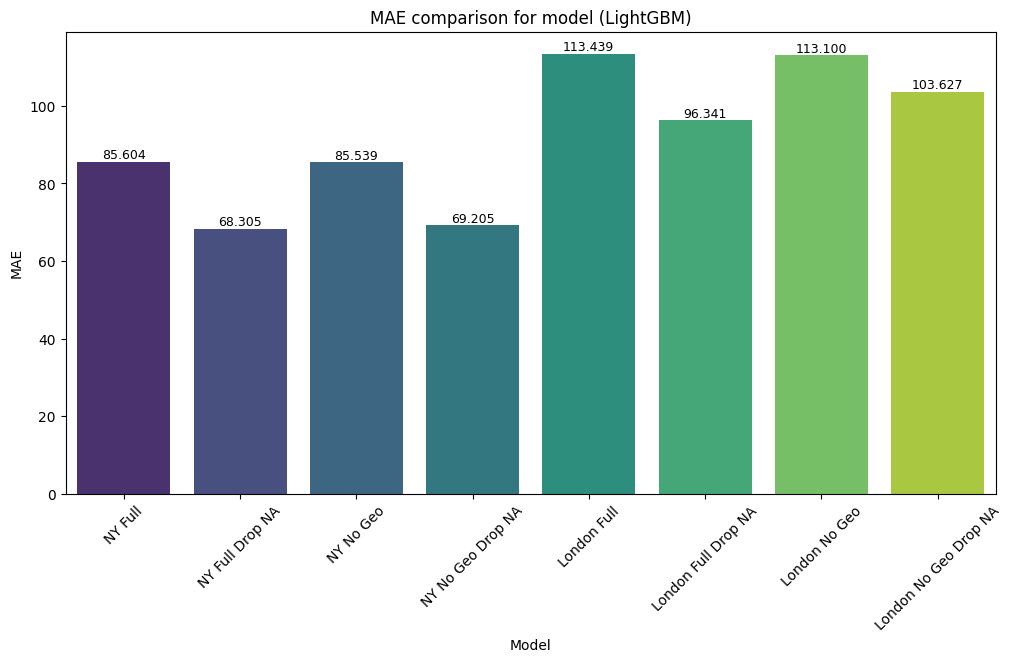

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


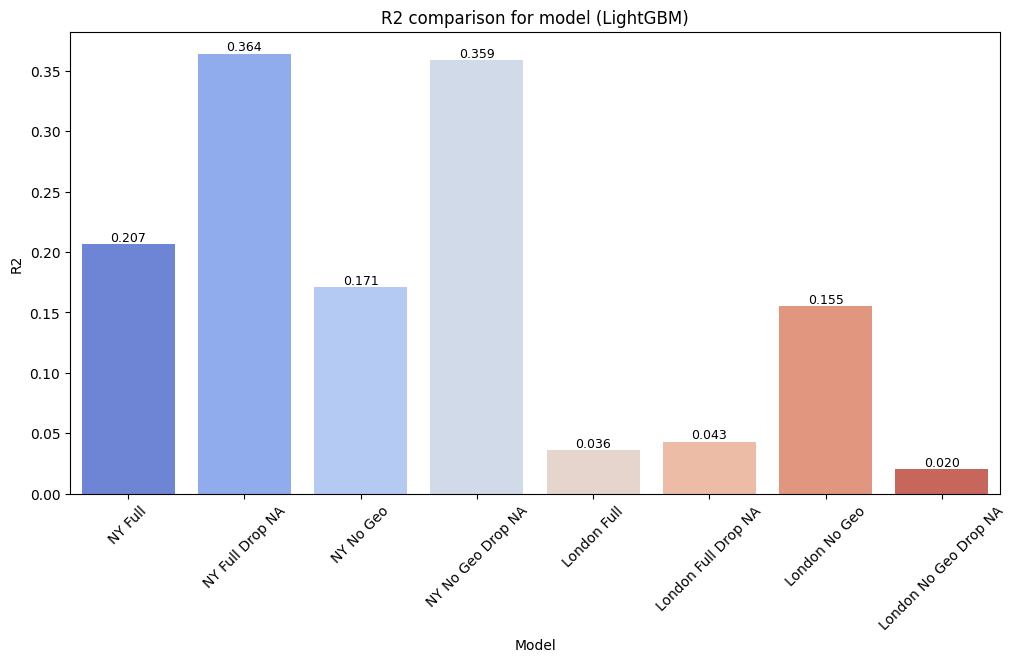

In [80]:
compare(train_and_evaluate_lgbm, "LightGBM")

NY Full data:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'MAE': 82.76276706064355, 'MSE': 165599.31965342007, 'R2 Score': 0.1654492920519085, 'Best Params': {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 70}}
NY Full data (drop nulls):
{'MAE': 67.10089204996137, 'MSE': 35013.51885927292, 'R2 Score': 0.3576569020978685, 'Best Params': {'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'num_leaves': 70}}
London Full data:
{'MAE': 107.03283830129097, 'MSE': 913888.0766014555, 'R2 Score': 0.06165185713063048, 'Best Params': {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 70}}
London Full data (drop nulls):
{'MAE': 102.56390269553704, 'MSE': 646132.2136595494, 'R2 Score': 0.05549569384781872, 'Best Params': {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}}
NY data without geo features:
{'MAE': 84.03546051993544, 'MSE': 170504.8063031776, 'R2 Score': 0.14072770886573926, 'Best Params': {'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 100, 'num

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


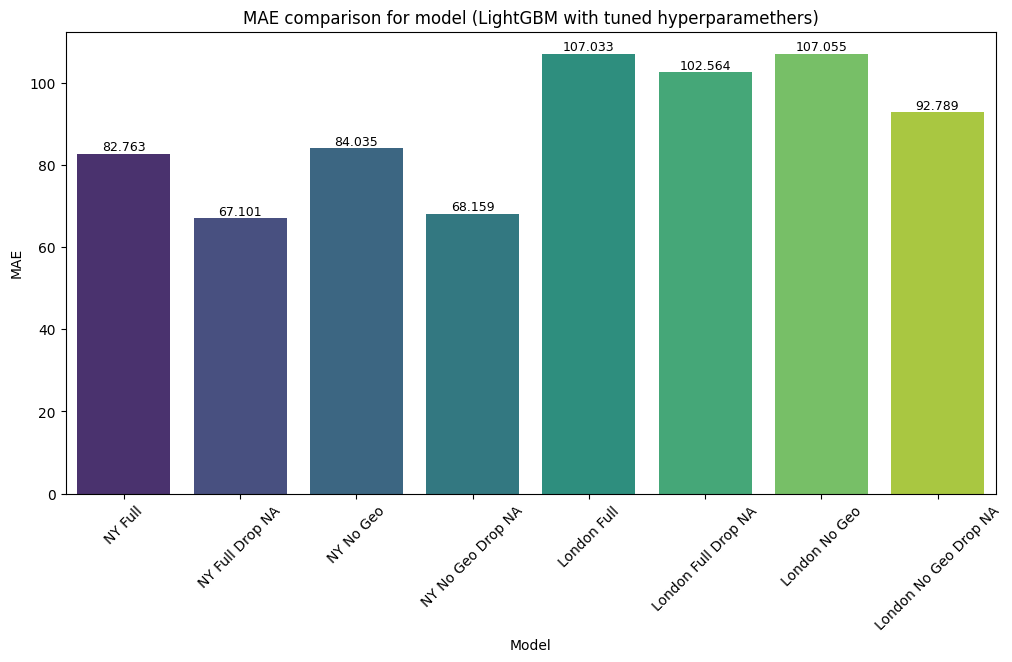

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


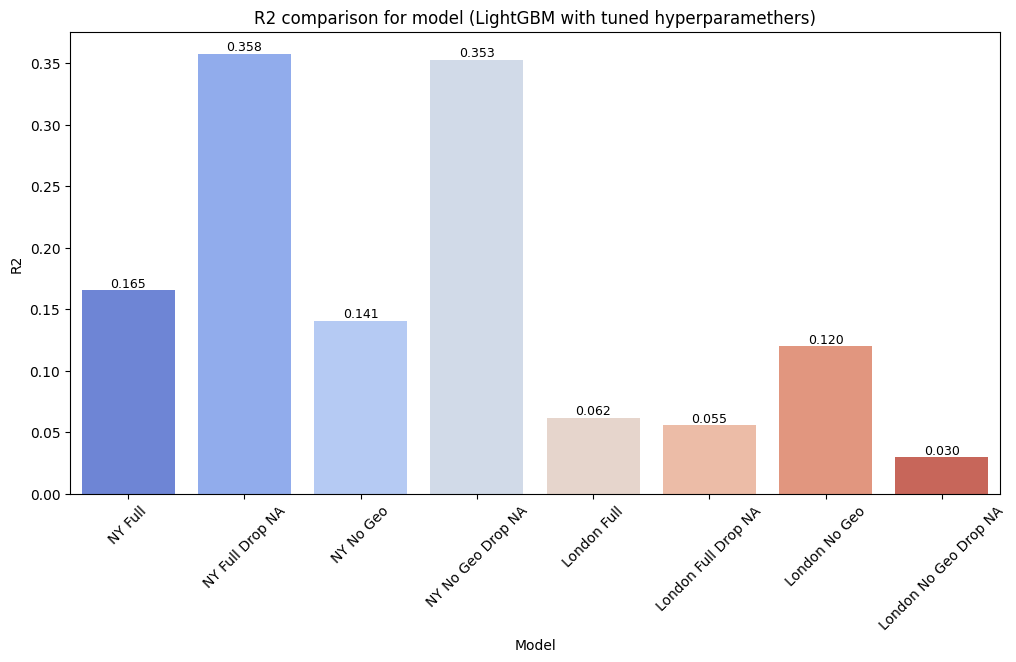

In [90]:
compare(train_and_evaluate_lgbm_tuned, "LightGBM with tuned hyperparamethers")

In [81]:
from sklearn.ensemble import RandomForestRegressor

def train_and_evaluate_rf(X, y, drop_null=False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }
    return model, metrics

NY Full data:
{'MAE': 80.85380610657542, 'MSE': 185080.78488333634, 'R2 Score': 0.06727092614123076}
NY Full data (drop nulls):
{'MAE': 65.38230035819637, 'MSE': 42651.95558784151, 'R2 Score': 0.21752539657628767}
London Full data:
{'MAE': 102.21577851094341, 'MSE': 949986.6834127747, 'R2 Score': 0.02458707695805251}
London Full data (drop nulls):
{'MAE': 85.0842405983794, 'MSE': 664738.9594247455, 'R2 Score': 0.028296691651084727}
NY data without geo features:
{'MAE': 81.55897618244944, 'MSE': 176924.69951179784, 'R2 Score': 0.10837415552132779}
NY data without geo features (drop nulls):
{'MAE': 70.02024072903498, 'MSE': 53004.84976287489, 'R2 Score': 0.0275956113589797}
London data without geo features:
{'MAE': 110.29878593997017, 'MSE': 882311.1080117673, 'R2 Score': 0.09407397816734031}
London data without geo features (drop nulls):
{'MAE': 90.48965094535633, 'MSE': 677640.1888485976, 'R2 Score': 0.009437909364916397}


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


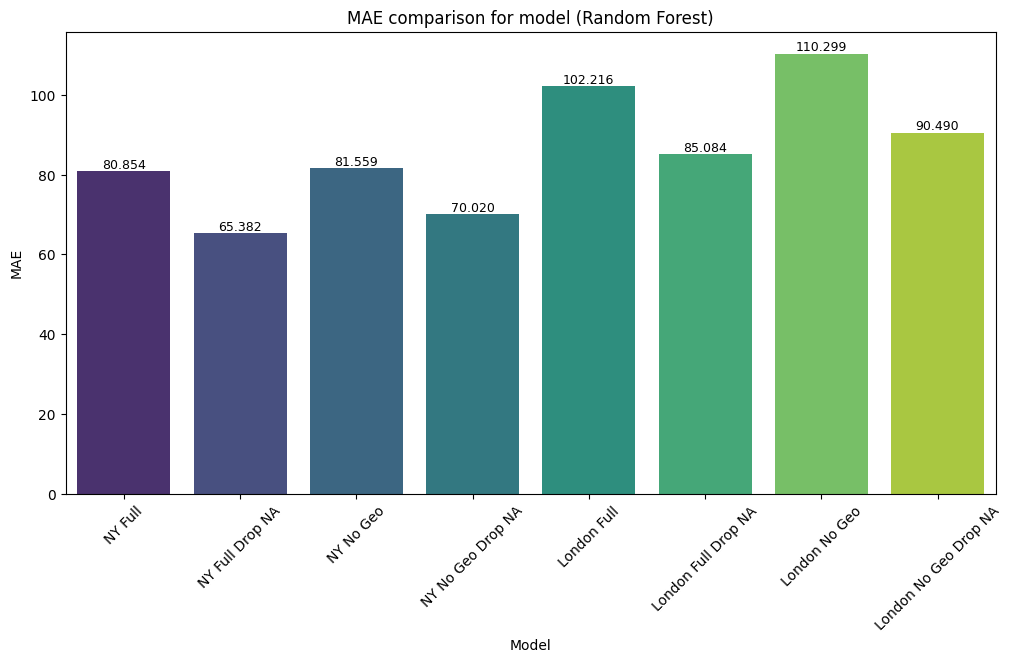

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


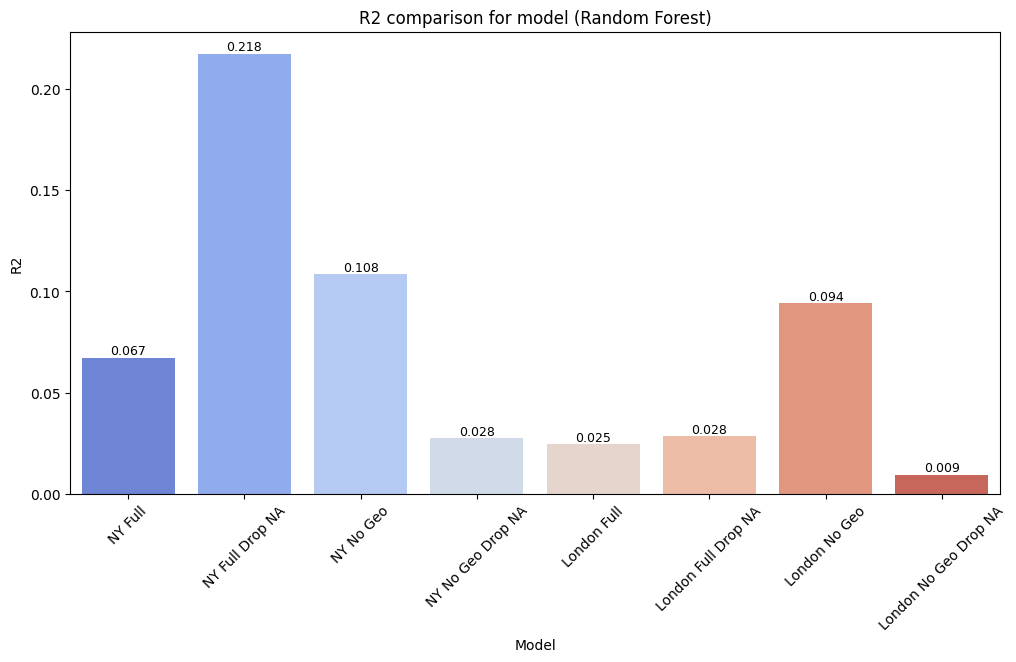

In [82]:
compare(train_and_evaluate_rf, "Random Forest")

In [91]:
def train_and_evaluate_rf_tuned(X, y, drop_null=False, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = RandomForestRegressor(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred),
        "Best Params": grid_search.best_params_
    }
    return best_model, metrics

NY Full data:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'MAE': 80.66095471040099, 'MSE': 181276.8530745177, 'R2 Score': 0.08644113765345107, 'Best Params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}}
NY Full data (drop nulls):
{'MAE': 64.59981312829606, 'MSE': 36489.326370276096, 'R2 Score': 0.3305823663354066, 'Best Params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}}
London Full data:


/Users/filipdziurdzia/Desktop/Uni/Semestr 8/Eksploracja Danych/Data-Exploration/venv1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The c

{'MAE': 101.65031344668476, 'MSE': 944044.8285191973, 'R2 Score': 0.03068796463493495, 'Best Params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}}
London Full data (drop nulls):


/Users/filipdziurdzia/Desktop/Uni/Semestr 8/Eksploracja Danych/Data-Exploration/venv1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'MAE': 86.27256765681261, 'MSE': 672530.070756917, 'R2 Score': 0.016907786954213577, 'Best Params': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}}
NY data without geo features:
{'MAE': 81.31144166649055, 'MSE': 176466.84299721566, 'R2 Score': 0.11068155919413825, 'Best Params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}}
NY data without geo features (drop nulls):
{'MAE': 67.27763154465141, 'MSE': 42032.11241387269, 'R2 Score': 0.22889677533375807, 'Best Params': {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}}
London data without geo features:


/Users/filipdziurdzia/Desktop/Uni/Semestr 8/Eksploracja Danych/Data-Exploration/venv1/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The c

{'MAE': 109.41285706770218, 'MSE': 876066.2015311542, 'R2 Score': 0.10048602855787359, 'Best Params': {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}}
London data without geo features (drop nulls):
{'MAE': 87.98484048976596, 'MSE': 679712.5756037226, 'R2 Score': 0.006408532137085254, 'Best Params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}}


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


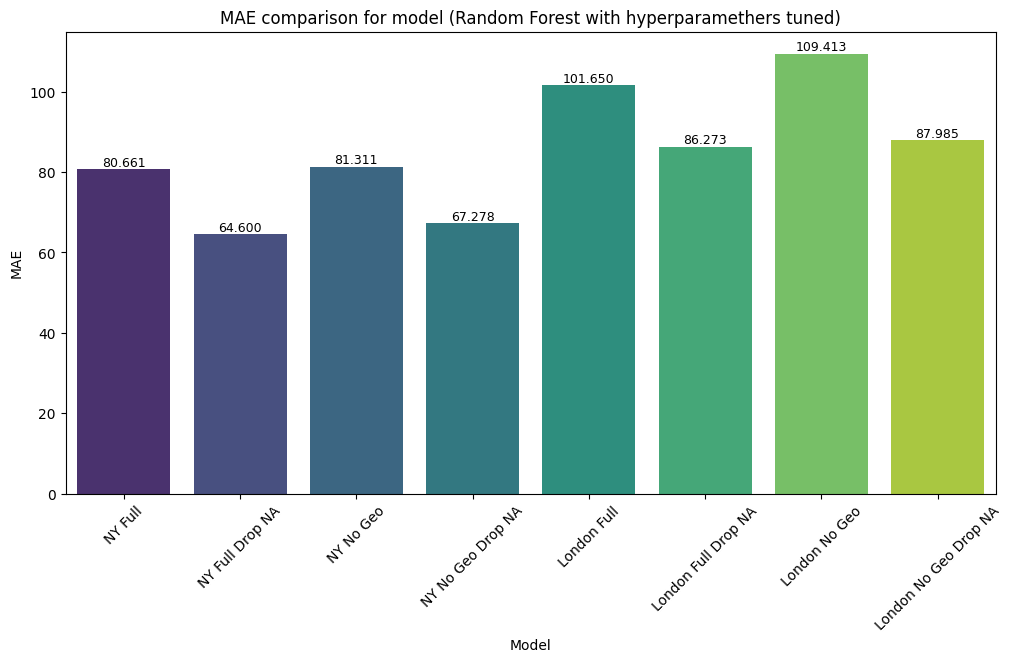

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


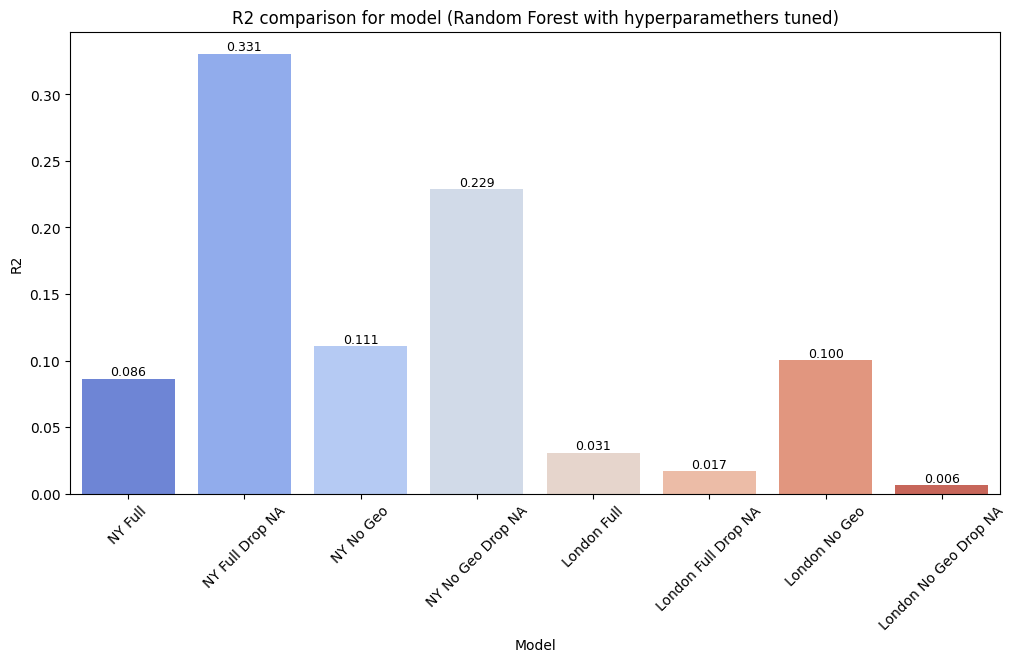

In [92]:
compare(train_and_evaluate_rf_tuned, "Random Forest with hyperparamethers tuned")

In [85]:
from sklearn.svm import SVR

def train_and_evaluate_svr(X, y, drop_null=True, test_size=0.2, random_state=42):
    if drop_null:
        X = X.dropna()
        y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2 Score": r2_score(y_test, y_pred)
    }
    
    return model, metrics

NY Full data:
{'MAE': 90.74352806983157, 'MSE': 54938.95513944243, 'R2 Score': -0.007886661766634662}
NY Full data (drop nulls):
{'MAE': 90.74352806983157, 'MSE': 54938.95513944243, 'R2 Score': -0.007886661766634662}
London Full data:
{'MAE': 109.76618723062184, 'MSE': 682559.9573801814, 'R2 Score': 0.0022462812969782364}
London Full data (drop nulls):
{'MAE': 109.76618723062184, 'MSE': 682559.9573801814, 'R2 Score': 0.0022462812969782364}
NY data without geo features:
{'MAE': 95.01118732009714, 'MSE': 56717.616000169844, 'R2 Score': -0.040517216038797876}
NY data without geo features (drop nulls):
{'MAE': 95.01118732009714, 'MSE': 56717.616000169844, 'R2 Score': -0.040517216038797876}
London data without geo features:
{'MAE': 114.14239122002233, 'MSE': 686582.6816809323, 'R2 Score': -0.003634063846321034}
London data without geo features (drop nulls):
{'MAE': 114.14239122002233, 'MSE': 686582.6816809323, 'R2 Score': -0.003634063846321034}


/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


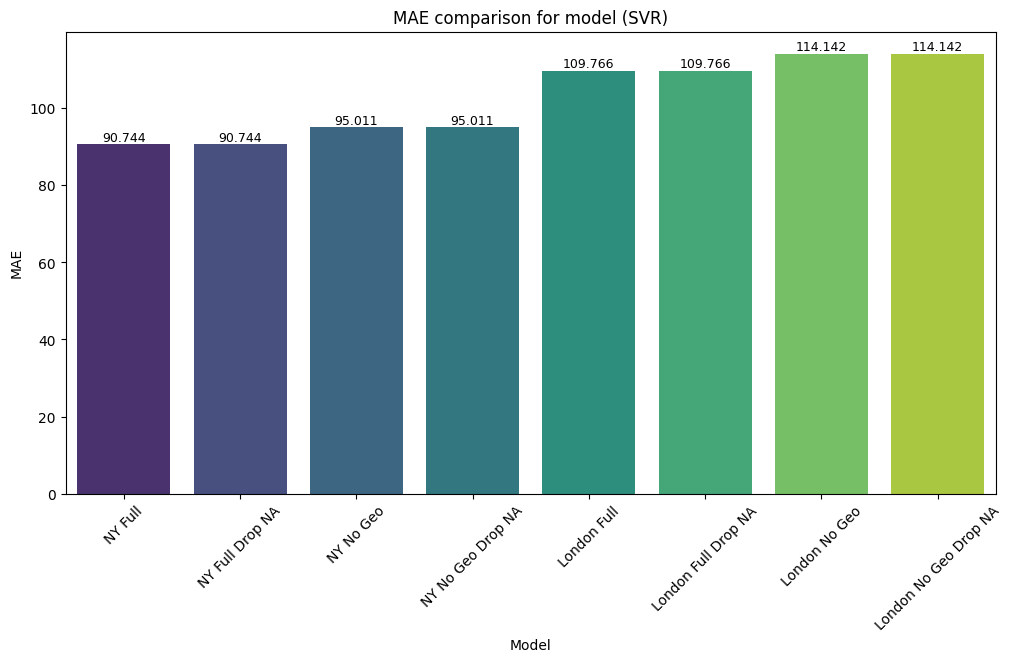

/var/folders/qt/z4grrnl54m18jsyt2pvlxy5m0000gn/T/ipykernel_28811/1413684124.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results, x='Model', y=metric, palette='viridis' if metric == 'MAE' else 'coolwarm')


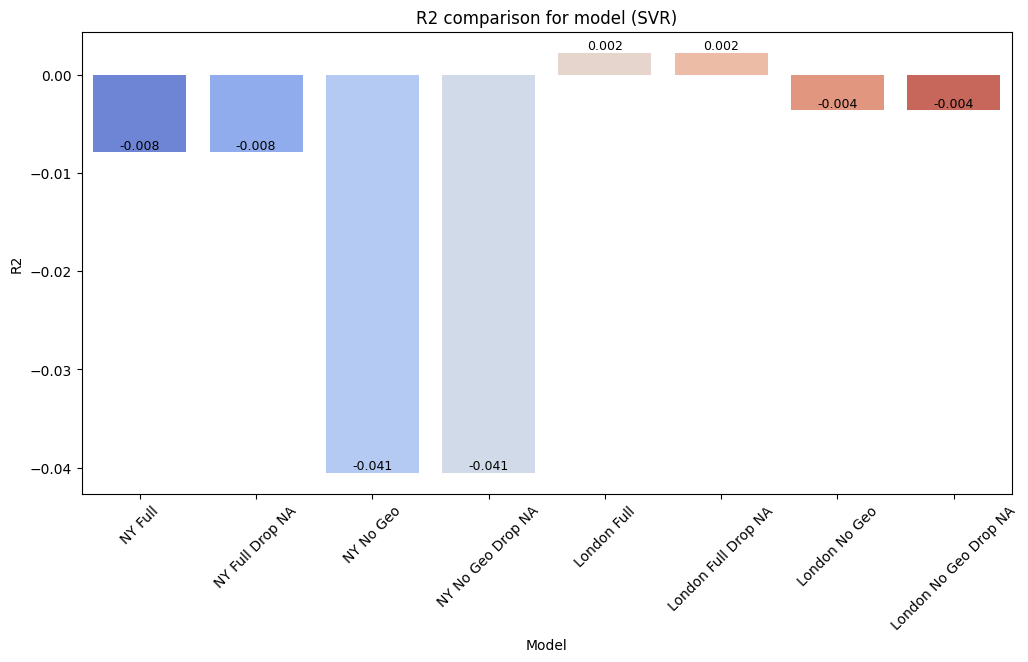

In [86]:
compare(train_and_evaluate_svr, "SVR")

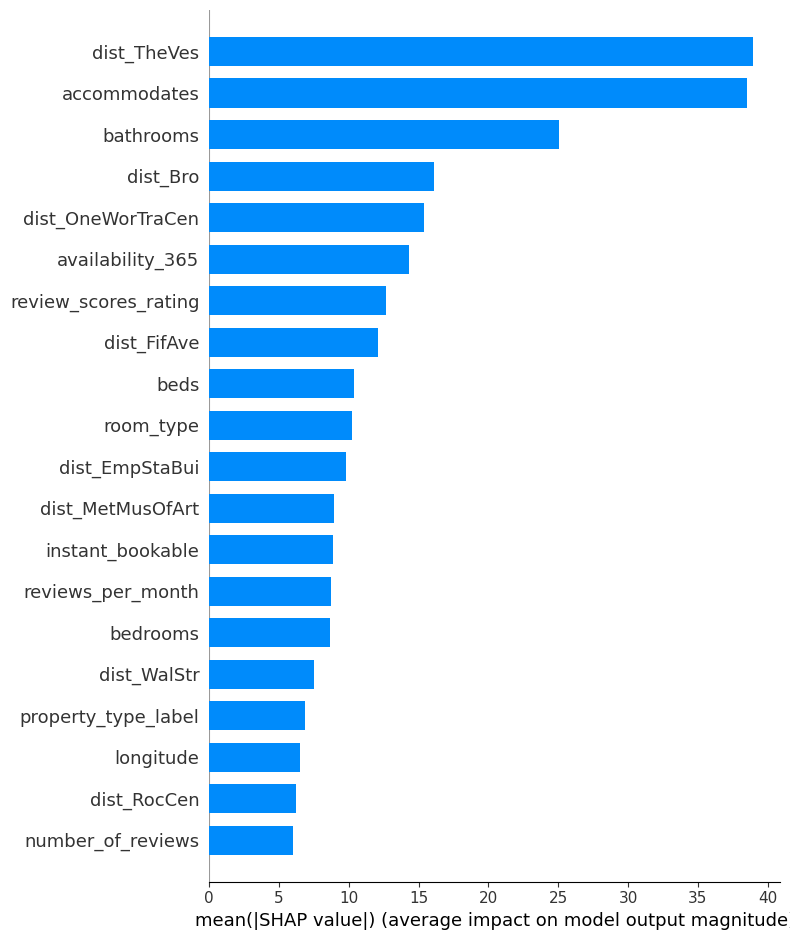

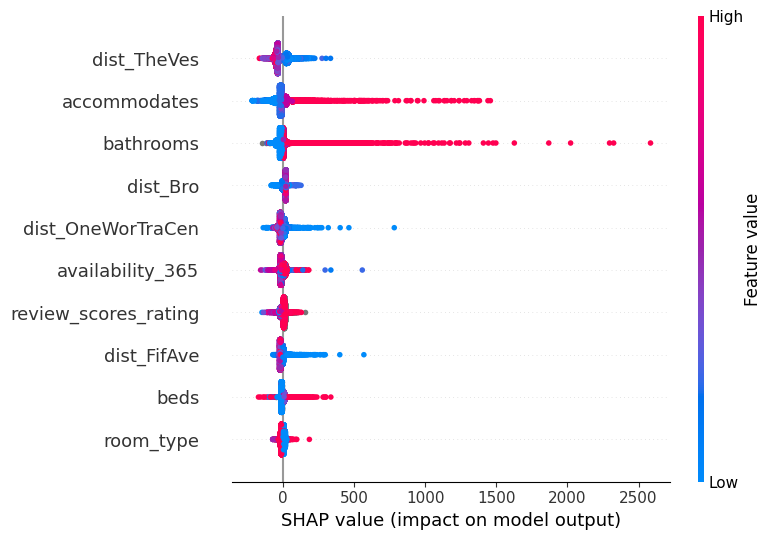

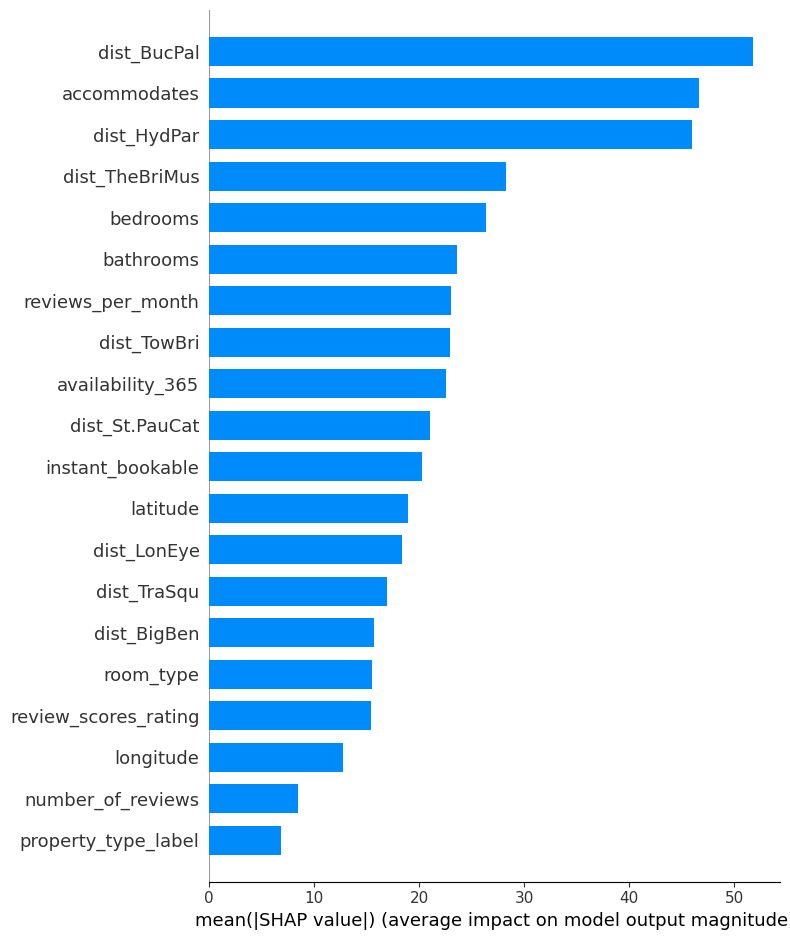

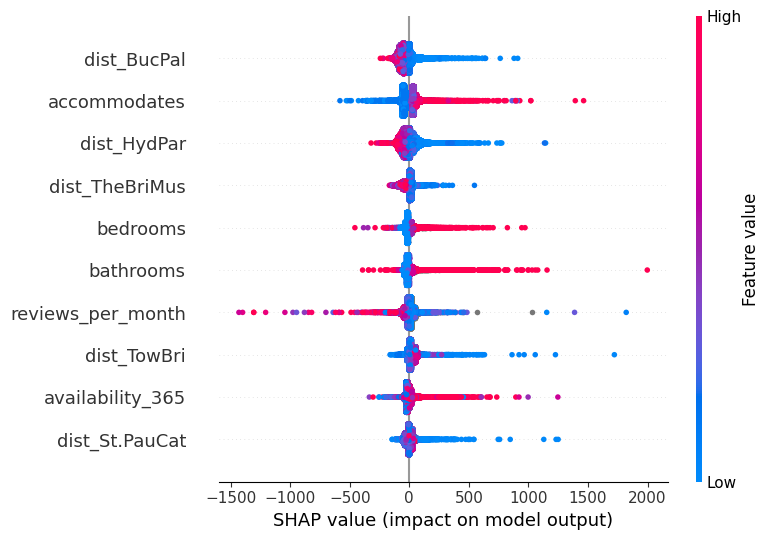

In [63]:
import shap

model_ny, _ = train_and_evaluate(X_ny, y_ny)

explainer = shap.TreeExplainer(model_ny)
shap_values = explainer.shap_values(X_ny)

shap.summary_plot(shap_values, X_ny, plot_type="bar")
shap.summary_plot(shap_values, X_ny, max_display=10)



model_london, _ = train_and_evaluate(X_london, y_london)

explainer = shap.TreeExplainer(model_london)
shap_values = explainer.shap_values(X_london)

shap.summary_plot(shap_values, X_london, plot_type="bar")
shap.summary_plot(shap_values, X_london, max_display=10)

